In [3]:
import numpy as np
import glob
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [35]:
trigger_file_path = '/ssd4/giorgian/tracks-pileup-october-2024/trigger/1/' 
nontrigger_file_path = '/ssd4/giorgian/tracks-pileup-october-2024/nontrigger/0/' 

In [36]:
trigger_files = [os.path.join(trigger_file_path, file) for file in glob.glob(os.path.join(trigger_file_path, '*.npz'))]
nontrigger_files = [os.path.join(nontrigger_file_path, file) for file in glob.glob(os.path.join(nontrigger_file_path, '*.npz'))]

In [37]:
def process(files):
    background_eliminated = []
    signal_kept = []
    
    for fname in tqdm(files):
        f = np.load(fname)
        start, end = f['edge_index']
        keep = f['model_edge_probability'] > 0.5
        pid = f['particle_id']
        hits = f['hit_cartesian']

        # we keep the start, and it is a background hit
        kept_start = np.isnan(pid[start[keep]])
        # we keep the end, and it is a background hit
        kept_end = np.isnan(pid[start[keep]])
        # look at how many edges we have where we kept the start or the end and we have a background hit

        # These are all the hits we kept that are background
        kept_hits_start = start[keep][kept_start]
        kept_hits_end = end[keep][kept_end]

        background = np.sum(np.isnan(pid))
        signal = np.sum(~np.isnan(pid))

        kept_hits = np.unique(np.concatenate([kept_hits_start, kept_hits_end]))
        background_eliminated.append(1 - kept_hits.shape[0]/background)

        # we keep the start, and it is not a background hit
        kept_start = ~np.isnan(pid[start[keep]])
        # we keep the end, and it is not a background hit
        kept_end = ~np.isnan(pid[start[keep]])
        # look at how many edges we have where we kept the start or the end and we have a background hit

        # These are all the hits we kept that are background
        kept_hits_start = start[keep][kept_start]
        kept_hits_end = end[keep][kept_end]

        kept_hits = np.unique(np.concatenate([kept_hits_start, kept_hits_end]))
        signal_kept.append(kept_hits.shape[0]/signal)
    background_eliminated = np.array(background_eliminated)
    signal_kept = np.array(signal_kept)

    return signal_kept, background_eliminated, trigger_kept, trigger_eliminated        

def process(files):
    background_eliminated = []
    signal_kept = []
    trigger_kept = []
    trigger_eliminated = []
    
    for fname in tqdm(files):
        f = np.load(fname)
        start, end = f['edge_index']
        keep = f['model_edge_probability'] > 0.5
        pid = f['particle_id']
        hits = f['hit_cartesian']
        trigger_node = f['trigger_node']
        trigger_hits = (trigger_node == 1) | (trigger_node == 2)
        n_trigger = np.sum(trigger_hits)
    
        # Background hits
        kept_start_bg = np.isnan(pid[start[keep]])
        kept_end_bg = np.isnan(pid[end[keep]])
        kept_hits_start_bg = start[keep][kept_start_bg]
        kept_hits_end_bg = end[keep][kept_end_bg]
        background = np.sum(np.isnan(pid))
        kept_hits_bg = np.unique(np.concatenate([kept_hits_start_bg, kept_hits_end_bg]))
        background_eliminated.append(1 - kept_hits_bg.shape[0] / background)
    
        # Signal hits
        kept_start_sig = ~np.isnan(pid[start[keep]])
        kept_end_sig = ~np.isnan(pid[end[keep]])
        kept_hits_start_sig = start[keep][kept_start_sig]
        kept_hits_end_sig = end[keep][kept_end_sig]
        signal = np.sum(~np.isnan(pid))
        kept_hits_sig = np.unique(np.concatenate([kept_hits_start_sig, kept_hits_end_sig]))
        signal_kept.append(kept_hits_sig.shape[0] / signal)
    
        # Trigger hits
        kept_start_trig = trigger_hits[start[keep]]
        kept_end_trig = trigger_hits[end[keep]]
        kept_hits_start_trig = start[keep][kept_start_trig]
        kept_hits_end_trig = end[keep][kept_end_trig]
        kept_hits_trig = np.unique(np.concatenate([kept_hits_start_trig, kept_hits_end_trig]))
        trigger_kept.append(kept_hits_trig.shape[0] / n_trigger)
        trigger_eliminated.append(1 - kept_hits_trig.shape[0] / n_trigger)
    
    background_eliminated = np.array(background_eliminated)
    signal_kept = np.array(signal_kept)
    trigger_kept = np.array(trigger_kept)
    trigger_eliminated = np.array(trigger_eliminated)
    
    return signal_kept, background_eliminated, trigger_kept, trigger_eliminated


In [39]:
len(trigger_files)

77904

In [38]:
s_kept, b_eliminated, t_kept, t_eliminated = process(trigger_files[:100000])

  0%|          | 0/77904 [00:00<?, ?it/s]

/tmp/ipykernel_3872486/3815849927.py:85: RuntimeWarning: invalid value encountered in scalar divide
  trigger_kept.append(kept_hits_trig.shape[0] / n_trigger)
/tmp/ipykernel_3872486/3815849927.py:86: RuntimeWarning: invalid value encountered in scalar divide
  trigger_eliminated.append(1 - kept_hits_trig.shape[0] / n_trigger)


Text(0, 0.5, 'Frequency')

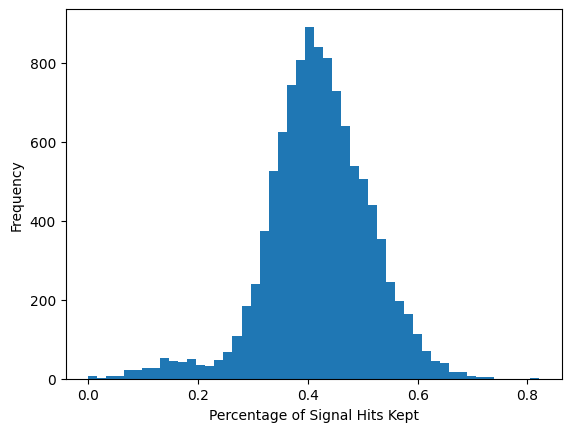

In [30]:
plt.hist(s_kept, bins=50)
plt.xlabel('Percentage of Signal Hits Kept')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

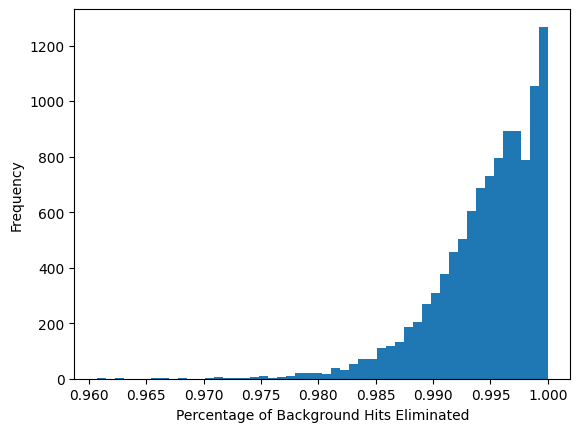

In [31]:
plt.hist(b_eliminated, bins=50)
plt.xlabel('Percentage of Background Hits Eliminated')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

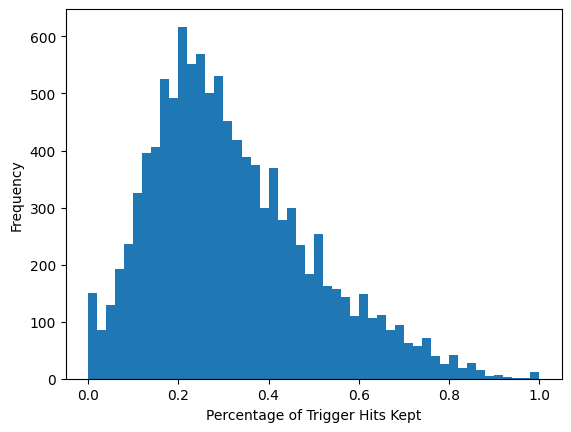

In [32]:
plt.hist(t_kept, bins=50)
plt.xlabel('Percentage of Trigger Hits Kept')
plt.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

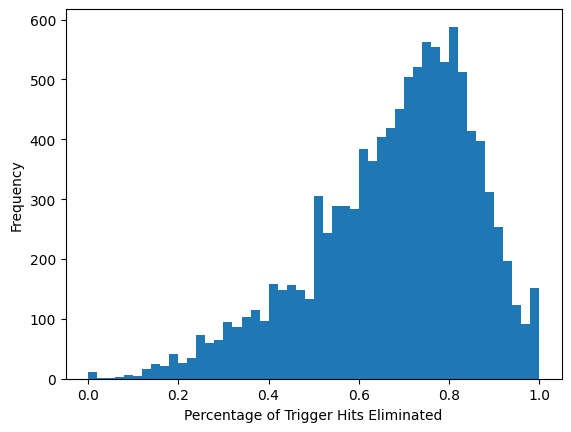

In [33]:
plt.hist(t_eliminated, bins=50)
plt.xlabel('Percentage of Trigger Hits Eliminated')
plt.ylabel('Frequency')

In [2]:
f = np.load(fname)
hits = f['hit_cartesian']
pred = f['model_edge_probability']
pid = f['particle_id']
plt.scatter(hits[:, 0], hits[:, 1])
start, end = f['edge_index']
for i, (u, v) in enumerate(zip(start, end)):
    h1 = hits[u]
    h2 = hits[v]
   #print(f'{h1[0]=} {h2[0]=} {h1[1]=} {h2[1]=}')
    p = pred[i] > 0.5
    if p and pid[u] == pid[v]:
        # true positive
        plt.plot([h1[0], h2[0]], [h1[1], h2[1]], color='green')
    elif p and pid[u] != pid[v]:
        # false positive
        plt.plot([h1[0], h2[0]], [h1[1], h2[1]], color='yellow')
    elif not p and pid[u] == pid[v]:
        # false negative
        plt.plot([h1[0], h2[0]], [h1[1], h2[1]], color='red')
    else:
        plt.plot([h1[0], h2[0]], [h1[1], h2[1]], color='black')

        

plt.xlim([-10, 10])
plt.ylabel([-10, 10])


NameError: name 'np' is not defined

In [31]:
h2[0]

np.float64(-1.8712624311887893)

In [103]:
trigger_pid = set()
trigger_ptype = set()
trigger_pptype = set()

for fname in tqdm(trigger_files[:100000]):
    f = np.load(fname)
    pid = f['particle_id']
    ptype = f['particle_type']
    pptype = f['parent_particle_type']
    trigger_pid.update(pid[~np.isnan(pid)])
    trigger_ptype.update(ptype[~np.isnan(ptype)])
    trigger_pptype.update(pptype[~np.isnan(pptype)])



  0%|          | 0/100000 [00:00<?, ?it/s]

In [104]:
nontrigger_pid = set()
nontrigger_ptype = set()
nontrigger_pptype = set()


for fname in tqdm(nontrigger_files[:100000]):
    f = np.load(fname)
    pid = f['particle_id']
    ptype = f['particle_type']
    pptype = f['parent_particle_type']
    nontrigger_pid.update(pid[~np.isnan(pid)])
    nontrigger_ptype.update(ptype[~np.isnan(ptype)])
    nontrigger_pptype.update(pptype[~np.isnan(pptype)])
    




0it [00:00, ?it/s]

In [89]:
trigger_pptype - nontrigger_pptype

{np.float64(1000040080.0)}

In [87]:
pid = f['particle_type']

In [ ]:
pid

In [ ]:
nontrigger_ptype = set()  
nontrigger_pid = set()

In [11]:
np.sum(f['trigger_node'])

np.int64(0)

In [15]:
f['particle_id'][~np.isnan(f['particle_id'])].astype(int)

array([   94,    78,    80,    67,    19,    20,    21,    12,    93,
          68,    88,    77,    26,    87,    94,    80,    67,    20,
          12,    19,    21,    93,    68,    88,    77,    26,    87,
          94,    78,    20,    80,    67,    19,    21,    12,    93,
          68,    88,    77,    26,    87, -4352,    68,    20,    19,
           3,    77, -1921,    87,    80,    67,    78,    93,    88,
          86,    12,    21,    92, -1921,    67,    80,    94,    78,
          93,    68,    21,    84,    77, -1921,    26,    86,    20,
          12,    19,    92,    87])

In [107]:
f['parent_particle_type']

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,  211.,  211.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,  -11.,    0.,    0.,    0.,    0., -211.,
       -211., -211., -211., -211., -211.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,  211.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0., -321.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,   22.,   22.,    0.,    0.,    0.,
         22.,   22.,   22.,    0.,    0.,    0.,  -11.,   22.])

In [122]:
f = np.load(trigger_files[5])
np.unique(f['parent_particle_type'][~np.isnan(f['parent_particle_type'])].astype(int))

array([-2212,  -321,  -211,     0,    11,    22,   211,   310,   321,
        2212])

In [123]:
list(f.keys())

['hit_cartesian',
 'hit_cylindrical',
 'layer_id',
 'n_pixels',
 'energy',
 'momentum',
 'interaction_point',
 'trigger',
 'has_trigger_pair',
 'track_origin',
 'edge_index',
 'edge_z0',
 'edge_phi_slope',
 'phi_slope_max',
 'z0_max',
 'trigger_node',
 'particle_id',
 'particle_type',
 'parent_particle_type',
 'active_node',
 'model_edge_probability',
 'model_edge_index']

In [130]:
keep = f['model_edge_probability'] > 0.5

In [127]:
start, end = f['edge_index']

In [131]:
start.shape, keep.shape

((1360,), (1360,))

In [136]:
list(f['particle_id'])

[np.float64(126.0),
 np.float64(112.0),
 np.float64(102.0),
 np.float64(nan),
 np.float64(nan),
 np.float64(13.0),
 np.float64(106.0),
 np.float64(26.0),
 np.float64(103.0),
 np.float64(nan),
 np.float64(31.0),
 np.float64(nan),
 np.float64(36.0),
 np.float64(nan),
 np.float64(97.0),
 np.float64(95.0),
 np.float64(98.0),
 np.float64(118.0),
 np.float64(88.0),
 np.float64(108.0),
 np.float64(nan),
 np.float64(nan),
 np.float64(52.0),
 np.float64(1.0),
 np.float64(53.0),
 np.float64(96.0),
 np.float64(54.0),
 np.float64(14.0),
 np.float64(16.0),
 np.float64(51.0),
 np.float64(117.0),
 np.float64(2.0),
 np.float64(nan),
 np.float64(130.0),
 np.float64(116.0),
 np.float64(122.0),
 np.float64(119.0),
 np.float64(-8046.0),
 np.float64(87.0),
 np.float64(110.0),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(nan),
 np.float64(121.0),
 np.float64(101.0),
 np.float64(30.0),
 np.float64(123.0),
 np.float64(112.0),
 np.float64(102.0),
 np.float64(nan),
 np.float64(126.0),
 np.f

In [144]:
kept_start = np.isnan(f['particle_id'][start[keep]])
kept_end = np.isnan(f['particle_id'][start[keep]])

In [145]:
kept_start.shape

(79,)

In [149]:
start[keep][kept_start]

array([ 242,  399,  500,  411,  541,  286, 1163,  411,  541,  284,  422,
        574,  793, 1203,  284])

In [150]:
start[keep][kept_end]

array([ 242,  399,  500,  411,  541,  286, 1163,  411,  541,  284,  422,
        574,  793, 1203,  284])

In [ ]:
np.unique(

In [146]:
np.sum(keep)

np.int64(79)

In [142]:
(valid_start & valid_end).mean()

np.float64(0.810126582278481)

In [139]:
valid_end.shape

(79,)

In [117]:
f['parent_particle_type']

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0., -321., -321.,    0.,    0.,    0.,    0.,    0.,
       -321.,    0.,    0.,    0.,    0.,    0.,    0.,    0., -321.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0., -321.,    0.,    0., -321.])

In [92]:
f['parent_particle_type'][~np.isnan(f['parent_particle_type'])].tolist()

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -211.0,
 -211.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -13.0,
 -13.0,
 -13.0,
 -13.0,
 0.0,
 -13.0,
 -13.0,
 -13.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 211.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 22.0,
 22.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -211.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 

In [94]:
f['trigger_node'].sum()

np.int64(0)

In [67]:
np.unique(f['particle_type'][~np.isnan(f['particle_type'])].astype(int))

array([     -2212,       -321,       -211,        -13,        -11,
               11,         13,        211,        321,       2212,
       1000010020, 1000010030])

In [68]:
f = np.load(nontrigger_files[0])
np.unique(f['parent_particle_type'][~np.isnan(f['parent_particle_type'])].astype(int))

array([-321, -211,  -11,    0,   11,   22,  211, 2212])

In [69]:
np.unique(f['particle_type'][~np.isnan(f['particle_type'])].astype(int))

array([-2212,  -321,  -211,   -13,   -11,    11,    13,   211,   321,
        2212])